# SEASONALITY ANALYSIS

This Jupyter Notebook contains main functions analyse seasonality in alpha diversity measure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from scipy import stats
from scipy import fft
from scipy import signal as sig
from scipy.fft import fft, fftfreq, ifft, rfft, rfftfreq
import math
from cmath import phase
from statsmodels.tsa.arima.model import ARIMA
import sympy as sym
from sympy import pi
from sklearn.linear_model import LinearRegression
import librosa
from scipy import signal

In [8]:
sns.set_style('whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['legend.title_fontsize'] = 'large'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

In [2]:
wd =  './data/'

# I. Shannon diversity index

In [3]:
n=0
male_alpha_df = pd.read_csv(wd + 'alpha_diversity/shannon/male_shannon_entropy.csv').iloc[n:150]
female_alpha_df = pd.read_csv(wd + 'alpha_diversity/shannon/female_shannon_entropy.csv').iloc[n:150]
donorA_alpha_df = pd.read_csv(wd + 'alpha_diversity/shannon/donorA_shannon_entropy.csv').iloc[n:150]
donorB_alpha_df = pd.read_csv(wd + 'alpha_diversity/shannon/donorB_shannon_entropy.csv').iloc[n:150]

datasets = [male_alpha_df, female_alpha_df, donorA_alpha_df, donorB_alpha_df]#.iloc[:150]]
subjects = ['Male', 'Female', 'DonorA', 'DonorB']

### Calculate flatness score

In [ ]:
def remove_trend(ts):
    
    lr = LinearRegression()
    X = ts.index.values.reshape(len(ts), 1)
    lr.fit(X, ts.values)
    trend = lr.predict(X)

    feature_detrended = ts.values - trend
    
    return feature_detrended

# flatness score
for i in range(0, 4):
    
    ts = datasets[i]['shannon_entropy']
    detrended_ts = remove_trend(ts).astype(float)
    f, t, Sxx = signal.spectrogram(detrended_ts) #get spectrogram
    flatness_score = librosa.feature.spectral_flatness(y=detrended_ts, S= Sxx, n_fft=(len(ts)//2), power=2)
    print(subjects[i], flatness_score[0][0])

In [11]:
# fft on full time series
def plot_fft(ts, n_modes, subject, plot=False):
    
    # Smoothin using rolling mean
    rolling_ts = ts.rolling(window=7).mean().dropna()
    train_detrend = remove_trend(rolling_ts)

    # Removing trend unig linear regression
    x = train_detrend.reshape(len(train_detrend), )
    
    n_modes = n_modes
    dt = 1 #sampling interval 
    n = len(x) #number of samples
    fhat = np.fft.fft(x, n) #computes the fft

    psd = fhat * np.conj(fhat)/n #power density spectrum
    freq = (1/(dt*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #half of index
    period = 1/freq #period


    train_fft_df = pd.DataFrame(list(zip(psd[idxs_half], np.real(psd[idxs_half]), period[idxs_half], freq[idxs_half])), 
                          columns = ['pds', 'pds_real', 'period [days]', 'freq [1/day]'])
    train_fft_df = train_fft_df.sort_values(by = ['pds_real'], ascending = False)
    train_fft_df = train_fft_df[(train_fft_df['period [days]'] < len(ts)//2) & (train_fft_df['period [days]'] > 2)]


    ### Filter signal only usig dominant mode 

    threshold = train_fft_df['pds_real'].values[0:n_modes]
    psd_idxs = np.isin(psd, threshold)
    psd_clean = psd * psd_idxs   #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal

    signal_filtered = np.fft.ifft(fhat_clean)

    score = np.round(stats.spearmanr(signal_filtered, train_detrend)[0], 2)
    
    
    if plot == True:
        
        # Plot spectrogram and ifft

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 3))
        markerline, stemlines, baseline = ax[0].stem(train_fft_df['period [days]'], train_fft_df['pds_real'], linefmt='black')
        markerline.set_markerfacecolor('black')
        markerline.set_markersize(7)
        markerline.set_markeredgewidth(0)
        stemlines.set_linewidth(.9)
        baseline.set_linewidth(3)
        plt.setp(baseline, 'color', 'black')


        ax[0].set_xlabel('period [day]', fontsize=14)
        ax[0].set_ylabel('amplitude [PDS]', fontsize=14)
        ax[0].grid(axis='y', linestyle = ':')
        ax[0].grid(axis='x', linestyle = ':', color='white')
        ax[0].set_ylim([0, train_fft_df['pds_real'].max()+0.25])
        
        plt.plot(train_detrend, 'k-', label = 'raw', lw=1.5)#, marker='o', markersize=4)
        plt.plot(signal_filtered, 'red', lw=3, label = 'smoothed')
        ax[1].set_xlabel('days', fontsize=14)
        ax[1].set_ylabel('Shannon diversity index', fontsize=14)
        ax[1].set_title(f'seasonal reconstruction score: {score}', fontsize=11)
        ax[1].legend(loc="upper right", ncol=2, fancybox=True, edgecolor='k', fontsize=10)
        plt.rcParams['legend.title_fontsize'] = 'small'

        ax[1].grid(axis='y', linestyle = ':')
        ax[1].grid(axis='x', linestyle = ':', color='white')
        plt.tight_layout()
        plt.show()
        
    elif plot == False: pass
    
    return score, train_fft_df.head(7)

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


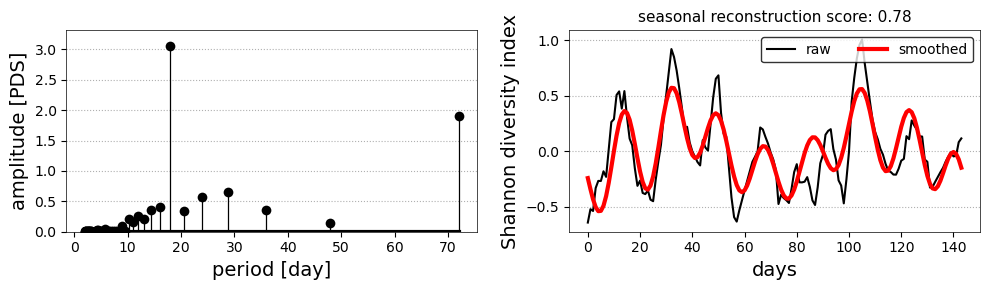

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


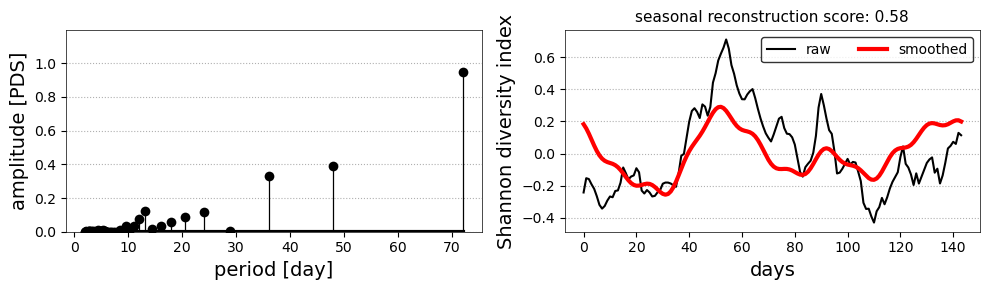

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


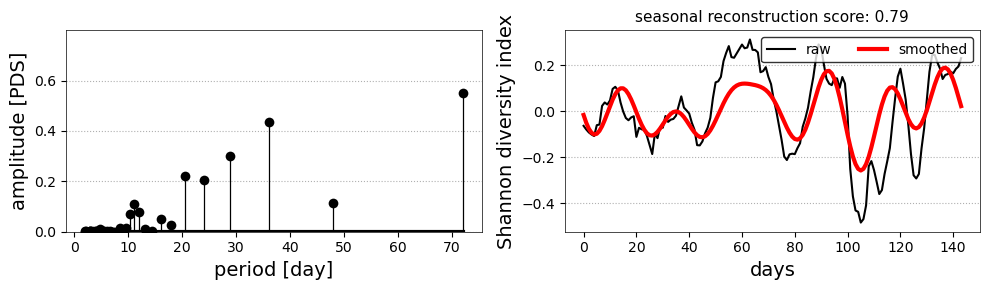

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


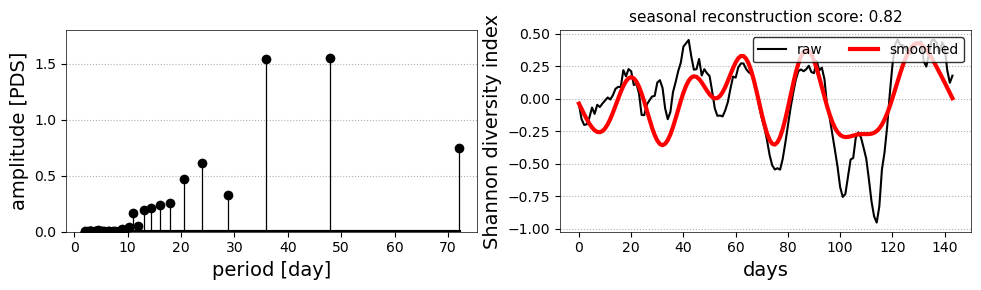

In [12]:
s, df1 = plot_fft(datasets[0], 5, subjects[0], True)
s, df2 = plot_fft(datasets[1], 5, subjects[1], True)
s, df3 = plot_fft(datasets[2], 5, subjects[2], True)
s, df4 = plot_fft(datasets[3], 5, subjects[3], True)

### Calculate dependency between nuber of Fourier modes vs seasonal reconstruction score

In [14]:
DF = []
for ts, s in zip(datasets, subjects):
    
    RHO = []
    for n in range(1, 11):
        try:
        
            rho = plot_fft(ts, n, s, False)[0]
            RHO.append(rho)
        except: pass
    df = pd.DataFrame(RHO, columns = ['coeff'])
    df['n_modes'] = range(1, 11)
    df['subject'] = s
    
    DF.append(df)
    
DF = pd.concat(DF)

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwo

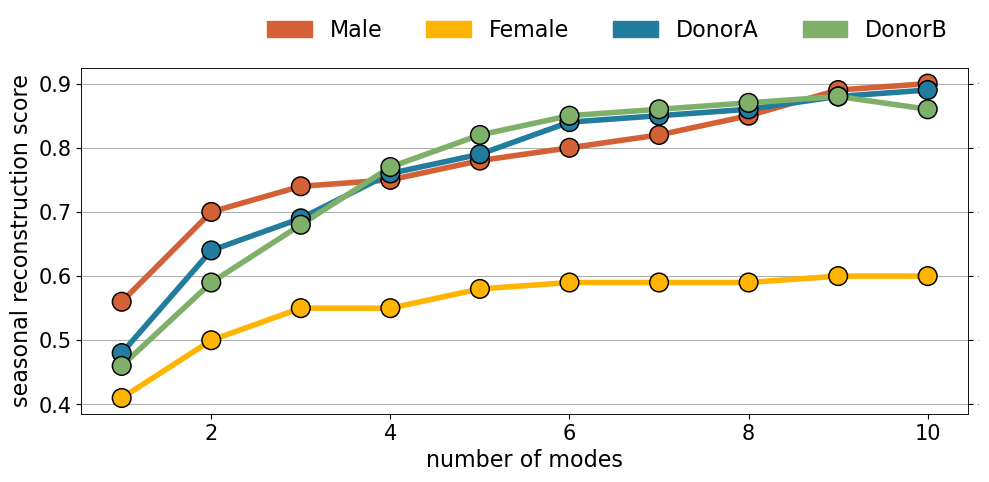

In [21]:
cmap = {'Male':'#d36135', 
        'Female':'#ffb400' ,
        'DonorA':'#227c9d', 
        'DonorB':'#7fb069'}

fig, ax1 = plt.subplots(figsize=(10,5), sharex=True, sharey=True)

sns.lineplot(data=DF, x = 'n_modes', y = 'coeff', hue = 'subject', palette = cmap,ax=ax1, lw=4, legend=False)
ax2 = ax1.twinx()
sns.scatterplot(data=DF, x = 'n_modes', y = 'coeff', hue = 'subject', legend=False, palette = cmap, s=180, edgecolor='k', ax=ax2)

s1_patch = mpatches.Patch(color='#d36135', label='Male')
s2_patch = mpatches.Patch(color='#ffb400', label='Female')
s3_patch = mpatches.Patch(color='#227c9d', label='DonorA')
s4_patch = mpatches.Patch(color='#7fb069', label='DonorB')

plt.legend(handles=[s1_patch, s2_patch, s3_patch, s4_patch], 
           fancybox=True, 
           edgecolor='white', 
           facecolor="white", 
           ncol=4, 
           fontsize=16,
           loc = 'upper right',
          bbox_to_anchor = (1, 1.2))

ax1.set_xlabel('number of modes', fontsize=16)
ax2.set_xlabel('')

ax1.set_ylabel('seasonal reconstruction score', fontsize=16)
ax2.set_ylabel('')

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = .5

ax1.grid(axis='y')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=0)
ax2.tick_params(axis='both', which='major', labelsize=0)

plt.tight_layout()
plt.savefig('nmodes_vs_corr.png', dpi=300)

# Faith's PD index

In [22]:
#faiths
wd =  './data/alpha_diversity/faiths_pd/'

male_alpha_df = pd.read_csv(wd + 'male_faiths_pd.csv').iloc[:150]
female_alpha_df = pd.read_csv(wd + 'female_faiths_pd.tsv', sep='\t', index_col = [0]).iloc[:150]
donorA_alpha_df = pd.read_csv(wd + 'donorA_faiths_pd.tsv', sep='\t', index_col = [0]).iloc[:150]
donorB_alpha_df = pd.read_csv(wd + 'donorB_faiths_pd.tsv', sep='\t', index_col = [0]).iloc[:150]

datasets = [male_alpha_df, female_alpha_df, donorA_alpha_df, donorB_alpha_df.iloc[:150]]
subjects = ['Male', 'Female', 'DonorA', 'DonorB']

In [23]:
# flatness score
for i in range(0, 4):
    
    ts = datasets[i]['faith_pd']
    detrended_ts = remove_trend(ts).astype(float)
    f, t, Sxx = signal.spectrogram(detrended_ts) #get spectrogram
    flatness_score = librosa.feature.spectral_flatness(y=detrended_ts, S= Sxx, n_fft=(len(ts)//2), power=2)
    print(subjects[i], flatness_score[0][0])

Male 0.048197334888932686
Female 0.023594520488923444
DonorA 0.14315977778759578
DonorB 0.025716603464617595


/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 150, using nperseg = 150
  .format(nperseg, input_length))


/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


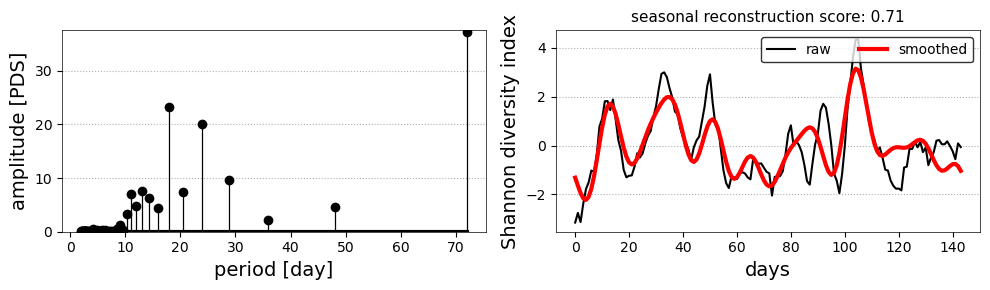

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


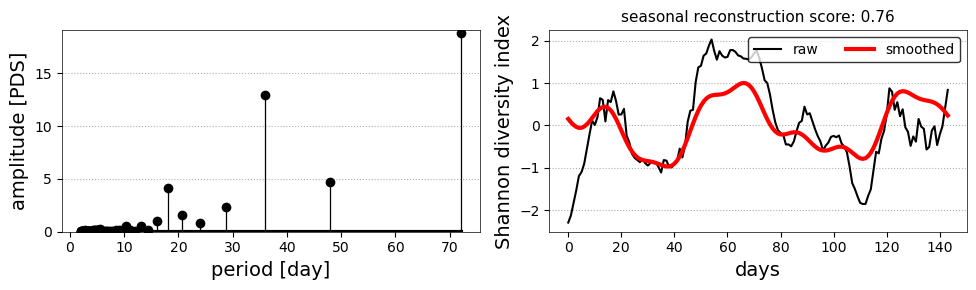

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


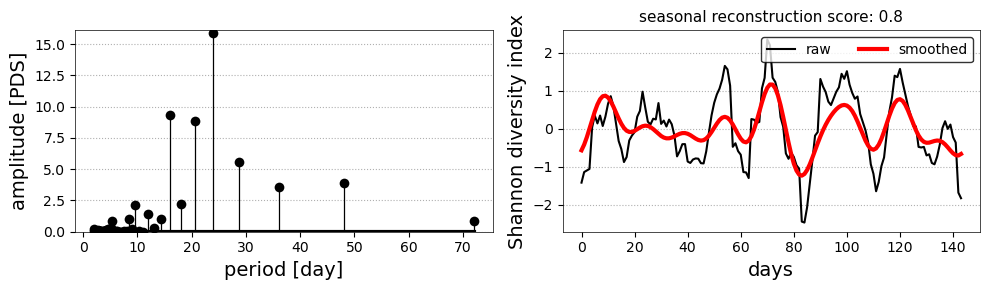

/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/MCB/zkarwowska/anaconda3/envs/time_series_env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


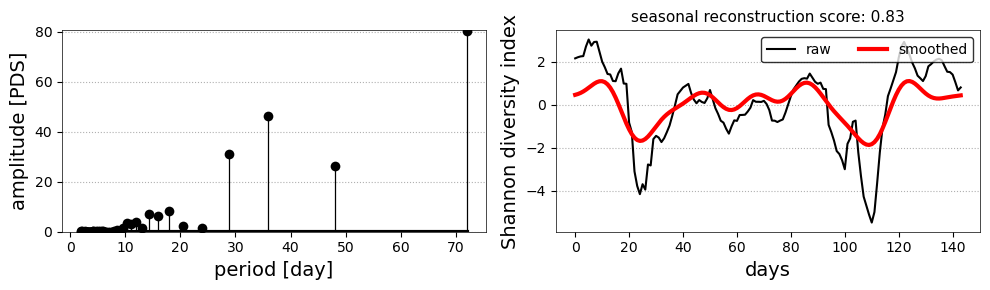

In [24]:
s, df1 = plot_fft(datasets[0], 5, subjects[0], True)
s, df2 = plot_fft(datasets[1], 5, subjects[1], True)
s, df3 = plot_fft(datasets[2], 5, subjects[2], True)
s, df4 = plot_fft(datasets[3], 5, subjects[3], True)

In [30]:
DF = []
for ts, s in zip(datasets, subjects):
    
    RHO = []
    for n in range(1, 10):
        
        rho = plot_fft(ts, n, s, False)[0]
        RHO.append(rho)
    df = pd.DataFrame(RHO, columns = ['coeff'])
    df['n_modes'] = range(1, 10)
    df['subject'] = s
    
    DF.append(df)
DF = pd.concat(DF)

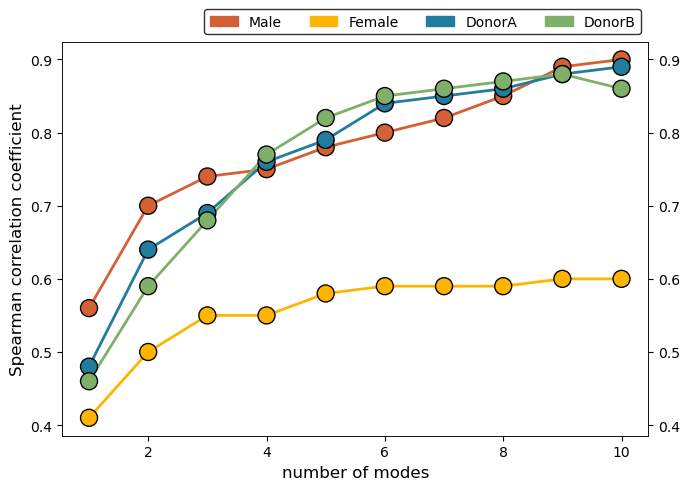

In [26]:
fig, ax1 = plt.subplots(figsize=(7,5), sharex=True, sharey=True)

sns.lineplot(data=DF, x = 'n_modes', y = 'coeff', hue = 'subject', palette = cmap,ax=ax1, lw=2, legend=False)
ax2 = ax1.twinx()
sns.scatterplot(data=DF, x = 'n_modes', y = 'coeff', hue = 'subject', legend=False, palette = cmap, s=150, edgecolor='k', ax=ax2)

s1_patch = mpatches.Patch(color='#d36135', label='Male')
s2_patch = mpatches.Patch(color='#ffb400', label='Female')
s3_patch = mpatches.Patch(color='#227c9d', label='DonorA')
s4_patch = mpatches.Patch(color='#7fb069', label='DonorB')

plt.legend(handles=[s1_patch, s2_patch, s3_patch, s4_patch], 
           #title='SUBJECT', 
           fancybox=True, 
           edgecolor='k', 
           facecolor="white", 
           ncol=4, 
           loc = 'upper right',
          bbox_to_anchor = (1, 1.1))

ax1.set_xlabel('number of modes', fontsize=12)
ax2.set_xlabel('')
ax1.set_ylabel('Spearman correlation coefficient', fontsize=12)
ax2.set_ylabel('')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = .5
plt.tight_layout()